In [7]:
! pip install tensorflow

In [8]:
# download model input data from DNANexus folder
#%%bash
!dx download "model_input" -r

[===========================================================>] Completed 4,543 of 4,543 bytes (100%) /opt/notebooks/model_input/README.mdd
[===========================================================>] Completed 3,051,744 of 3,051,744 bytes (100%) /opt/notebooks/model_input/Indel_VCFs.gene_scores_matrix.tsv.gzz
[===========================================================>] Completed 1,588,467 of 1,588,467 bytes (100%) /opt/notebooks/model_input/SNP_VCFs.gene_scores_matrix.tsv.gzz
[===========================================================>] Completed 228,801 of 228,801 bytes (100%) /opt/notebooks/model_input/SNP_VCFs.cS2G_scores_matrix.tsv.gzz
[===========================================================>] Completed 6,472,066 of 6,472,066 bytes (100%) /opt/notebooks/model_input/Indel_VCFs.genotype_matrix.tsv.gzz
[===========================================================>] Completed 638 of 638 bytes (100%) /opt/notebooks/model_input/pheno_data.tsvv
[===================================

In [32]:
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Input, Dense
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load and preprocess data

In [11]:
insertions_data = pd.read_csv('model_input/HERV_K_Insertions.txt',sep='\t',index_col=0)

In [83]:
input1 = insertions_data.values
X = [input1]
input_shape = input1.shape[-1]

In [89]:
for i, ii in enumerate(insertions_data):
    print(ii)

chr1:111802591-111802598
chr1:223578303-223578310
chr4:9603239-9603245
chr4:9981605-9981606
chr4:190966833-190966919
chr5:4537604-4537605
chr5:64388439-64388446
chr5:80442265-80442272
chr6:16004793-16004926
chr6:32643383-32643537
chr6:32648035-32648041
chr6:161270898-161270905
chr7:158773312-158773459
chr8:146086169-146086170
chr9:132205208-132205208
chr10:101016044-101016228
chr10:134444012-134444013
chr11:60449889-60449889
chr12:44313656-44313662
chr12:124066476-124066483
chr13:90743182-90743189
chr15:28430044-28430186
chr15:63374593-63374600
chr19:21841536-21841542
chr19:22414303-22414381
chr19:22457244-22457245
chr19:29855781-29855787
chr19:57996939-57996940
chr20:12402386-12402392
chr22:23852639-23852640
chrX:93606603-93606604


# Model

In [45]:
#AUTOENCODER MODEL DEFINITION
# This is the size of our encoded representations
encoding_dim = 5 

# This is our input image
input_layer = keras.Input(shape=input_shape,name='input')

# "encoded" is the encoded representation of the input, we can add strong regularization here if n_samples << n_features
encoded = layers.Dense(encoding_dim, activation='relu',name='compressed_representation')(input_layer)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(input_shape, activation='sigmoid',name='reconstructed_output')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_layer, decoded)

In [46]:
tf.keras.utils.plot_model(autoencoder, "multi_input_and_output_model.png", show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Training

In [47]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [48]:
hisotry = autoencoder.fit(X,X,
                epochs=50,
                batch_size=5,
                shuffle=True,
                validation_split=0.2,verbose=2)

Epoch 1/50
4/4 - 0s - loss: 0.6688 - val_loss: 0.6643
Epoch 2/50
4/4 - 0s - loss: 0.6654 - val_loss: 0.6604
Epoch 3/50
4/4 - 0s - loss: 0.6620 - val_loss: 0.6567
Epoch 4/50
4/4 - 0s - loss: 0.6589 - val_loss: 0.6530
Epoch 5/50
4/4 - 0s - loss: 0.6556 - val_loss: 0.6493
Epoch 6/50
4/4 - 0s - loss: 0.6522 - val_loss: 0.6455
Epoch 7/50
4/4 - 0s - loss: 0.6486 - val_loss: 0.6414
Epoch 8/50
4/4 - 0s - loss: 0.6452 - val_loss: 0.6372
Epoch 9/50
4/4 - 0s - loss: 0.6414 - val_loss: 0.6330
Epoch 10/50
4/4 - 0s - loss: 0.6374 - val_loss: 0.6285
Epoch 11/50
4/4 - 0s - loss: 0.6335 - val_loss: 0.6241
Epoch 12/50
4/4 - 0s - loss: 0.6293 - val_loss: 0.6197
Epoch 13/50
4/4 - 0s - loss: 0.6250 - val_loss: 0.6152
Epoch 14/50
4/4 - 0s - loss: 0.6207 - val_loss: 0.6106
Epoch 15/50
4/4 - 0s - loss: 0.6164 - val_loss: 0.6059
Epoch 16/50
4/4 - 0s - loss: 0.6116 - val_loss: 0.6012
Epoch 17/50
4/4 - 0s - loss: 0.6071 - val_loss: 0.5964
Epoch 18/50
4/4 - 0s - loss: 0.6024 - val_loss: 0.5913
Epoch 19/50
4/4 - 0

# Use encoder to reduce dimensions

In [49]:
# encoder part, to compress data with after training
encoder = keras.Model(input_layer, encoded)
encoded_input = Input(shape = (encoding_dim, ))

In [50]:
encoded_train = pd.DataFrame(encoder.predict(X))
encoded_train = encoded_train.add_prefix('feature_')

In [51]:
print(encoded_train.shape)
encoded_train

(20, 5)


,feature_0,feature_1,feature_2,feature_3,feature_4
0,1.145717,1.592631,0.744760,0.0,1.348833
1,1.886658,2.728269,2.078684,0.0,2.333317
2,2.492687,3.053942,1.878806,0.0,1.812229
3,3.676575,3.771553,1.042752,0.0,0.398188
4,2.469799,2.894288,0.391026,0.0,0.469780
5,2.126485,1.761699,0.000000,0.0,0.243871
6,2.509242,1.820783,1.366839,0.0,0.969464
7,2.400369,2.199226,0.490438,0.0,0.381688
8,1.410719,1.648086,0.393364,0.0,0.665049
9,1.454444,2.553384,1.209379,0.0,1.378522


# Node ranking

In [59]:
compressed_w = autoencoder.get_layer('compressed_representation').get_weights()[0].flatten()

Populating the interactive namespace from numpy and matplotlib


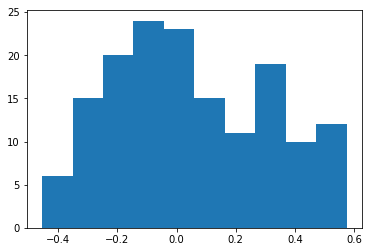

In [60]:
%pylab inline
hist(compressed_w);

In [75]:
mod_w = autoencoder.get_layer('reconstructed_output').get_weights()[0].flatten()
tot_w = compressed_w*mod_w[0]
mod_order = tot_w.argsort()[::-1] # to rank from larger to smaller
mod_ranks = mod_order.argsort()

df = pd.DataFrame(columns=['Rank','Score'])
df['Rank'] = mod_ranks
df['Score'] = tot_w
output_dfs = df.sort_values(by=['Rank'])

In [76]:
print(output_dfs)

     Rank     Score
107     0  0.164591
105     1  0.160969
109     2  0.158162
106     3  0.156264
130     4  0.151363
..    ...       ...
33    150 -0.105190
22    151 -0.108153
153   152 -0.109463
67    153 -0.124753
119   154 -0.130206

[155 rows x 2 columns]


In [79]:
encoded.shape

TensorShape([None, 5])

In [80]:
decoded.shape

TensorShape([None, 31])

In [ ]:
for i, i_name in enumerate(insertions_data):
    features_w = autoencoder.get_layer('compressed_representation').get_weights()[0].flatten()
    tot_w = mod_w[i]*features_w
    mod_order = tot_w.argsort()[::-1] # to rank from larger to smaller
    mod_ranks = mod_order.argsort()

#     df = pd.DataFrame(columns=['Feature_ID','Rank','Score'])
#     df['Feature_ID'] = genes
#     df['Rank'] = mod_ranks
#     df['Score'] = tot_w

# Insertion ranking

In [184]:
dataframes = {}
insertion = insertions_data.keys()

mod_w = autoencoder.get_layer('reconstructed_output').get_weights()[1].flatten()

mod_df = pd.DataFrame(columns=['Insertion','Weight'])
mod_df['Insertion'] = insertion
mod_df['Weight'] = mod_w

In [196]:
from pathlib import Path
output_path = 'dimensionality_reduction'

# make dir
Path(output_path).mkdir(parents=True, exist_ok=True)

# save insertion weigths
mod_df.to_csv(output_path +'/insertion_weights',sep='\t',index=False,header=mod_df.columns)

In [197]:
# upload output to DNAnexus
!dx upload -r dimensionality_reduction

[===========================================================>] Uploaded 1,127 of 1,127 bytes (100%) dimensionality_reduction/insertion_weights
